# Introduction


In this homework, you'll be required to load in a dataset which has about 500 features. By using
Lasso ($L^1$) regression, we'll find the optimal constraint on the $L^1$ norm which gives us the best
$R^2$. Then we'll plot the results.

Recall we minimize the following on ** training data: $(x_i,y_i)$**

$$\min_{\beta} \frac{1}{N} \sum_{i=1}^N (y_i - \beta \cdot x_i)^2 + \lambda \|\beta \|_{L^1}.$$


Denoting $\beta_{\lambda}$ as the minimum of the above, we then choose $\lambda$ to maximize $R^2$ on **testing data: $(x_j,y_j)$**

$$ \max_{\lambda} 1 - \frac{\sum_{j} (y_j - \beta_{\lambda} \cdot x_j)^2}{\sum_j (y_j - \bar y)^2}$$


# Lasso Regularization

## Problem 1

a) Load in hw2data.csv from ../data into a pandas dataframe.

b) Set y to be the y variable in the dataframe from a and X to be the remaining features.

c) As shown in the Booking.com example, using Lasso regression, find the regularization strength
which optimizes the $R^2$. 

**Hint:** Take a range of alpha from `np.logspace(-8,-3,1000)`

C:\Users\Ayan Nandi\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


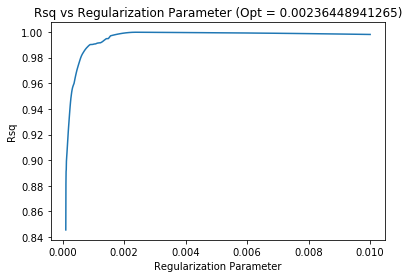

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
%matplotlib inline

df = pd.read_csv("hw2data.csv")
y = df["y"]
X = df[df.columns[:-1]]
alphas = np.logspace(-4,-2,100)
train_errors=[]
test_errors=[]
_coeffs = []
alpha_optim=0


X_trn, X_test, y_trn, y_test = train_test_split(X.values,y.values,test_size = 0.33,random_state = 40)

for a in alphas:
    lr = Lasso(alpha=a)
    lr.fit(X_trn,y_trn)
    train_errors.append(lr.score(X_trn,y_trn))
    test_errors.append(lr.score(X_test,y_test))
    _coeffs.append(lr.coef_)

alpha_optim = alphas[np.argmax(test_errors)]

plt.plot(alphas,test_errors)
plt.xlabel("Regularization Parameter")
plt.ylabel("Rsq")
plt.title("Rsq vs Regularization Parameter (Opt = {})".format(alpha_optim))
plt.show()





d) Plot the training perforamnce versus the testing performance, and observe whree the test performance is
maximized. I've written an outline of the code you need.

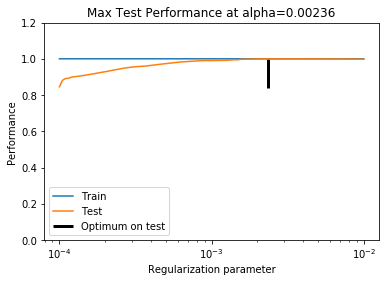

In [2]:
  



plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')
plt.title("Max Test Performance at alpha={}".format(np.round(alpha_optim,5)))

plt.show()


e) Plot the top coefficients based on this optimal paramter. Why do you think so many are zero? 

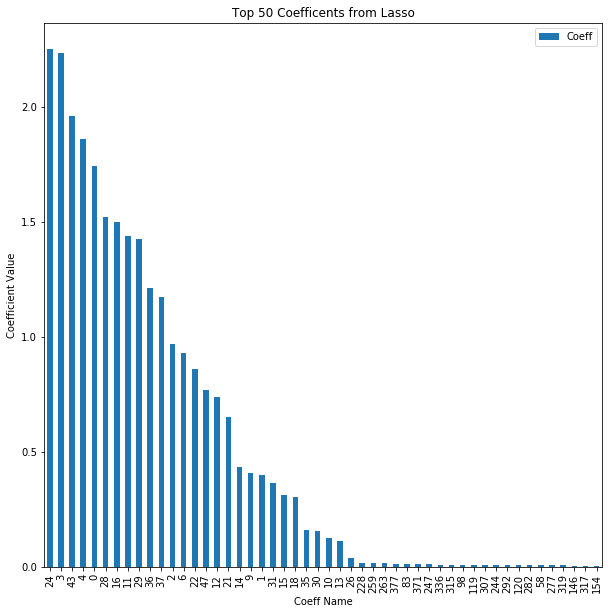

In [3]:
opt_coeffs = pd.DataFrame(index=X.columns,data=_coeffs[np.argmax(test_errors)],columns=["Coeff"])
opt_coeffs.index.name = "Coeff Name"
opt_coeffs = opt_coeffs.sort_values(by=["Coeff"],ascending=False)
opt_coeffs[:50].plot(kind="bar",figsize=(10,10))
plt.title("Top 50 Coefficents from Lasso")
plt.ylabel("Coefficient Value")
plt.show()

Lasso, or L1 Regularized Regression has level sets of the constraints which are boxes instead of spheres.  As a result, these constraint regions have fewer tangents, and will result in more zero-valued features than an L2 Regularized Regression (such as ridge).

f) Compute the $R^2$ with the optimal coefficient found above on 5 folds using cross_val_score and plot the
results. Does the model work well on all random subsets?

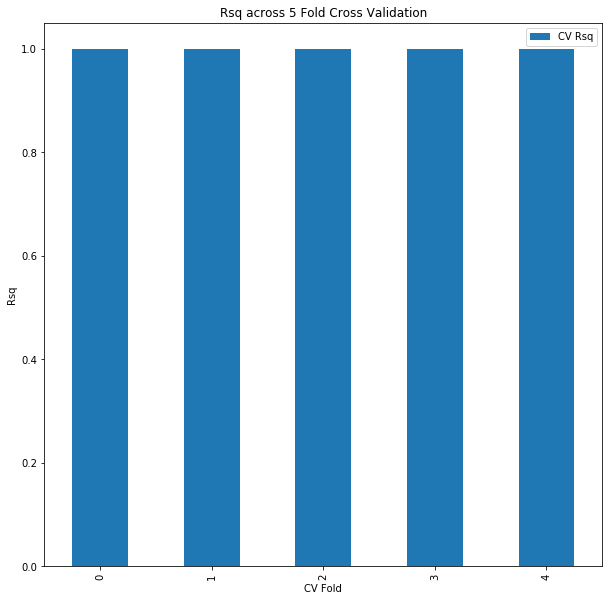

In [4]:
from sklearn.model_selection import cross_val_score
lr = Lasso(alpha=alpha_optim)
cv_scores = cross_val_score(lr,X.values,y.values,cv=5)
cv_scores = pd.DataFrame(index=range(5),data=cv_scores,columns=["CV Rsq"])
cv_scores.plot(kind="bar",figsize=(10,10))
plt.xlabel("CV Fold")
plt.ylabel("Rsq")
plt.title("Rsq across 5 Fold Cross Validation")
plt.show()



Based on the high CV scores across 5 random folds, this model generalizes well across the random subsets.

g) Repeat e) but using cross validation. Use error bars on the features which are the standard deviation of the 
coefficiens obtained above. For this problem I"ll walk you through the code. You just need to apply your optimal
$\alpha$ found above. 

In [5]:
from sklearn.cross_validation import KFold
from sklearn import preprocessing
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        coeffs.append(clf.coef_)
    return coeffs



scaler = preprocessing.StandardScaler()
X_scaled = X.as_matrix().astype(np.float)
X_scaled = scaler.fit_transform(X)

coeffs=run_cv_coeffs(X_scaled,np.array(y),Lasso,alpha=alpha_optim)

C:\Users\Ayan Nandi\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][i] + coeffs[1][i] + coeffs[2][i] + coeffs[3][i] + coeffs[4][i])/5 for i in range(0,len(X.columns))]
    coeffs_std = [np.std([coeffs[0][i],coeffs[1][i],coeffs[2][i],coeffs[3][i],coeffs[4][i]]) for i in range(0,len(X.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

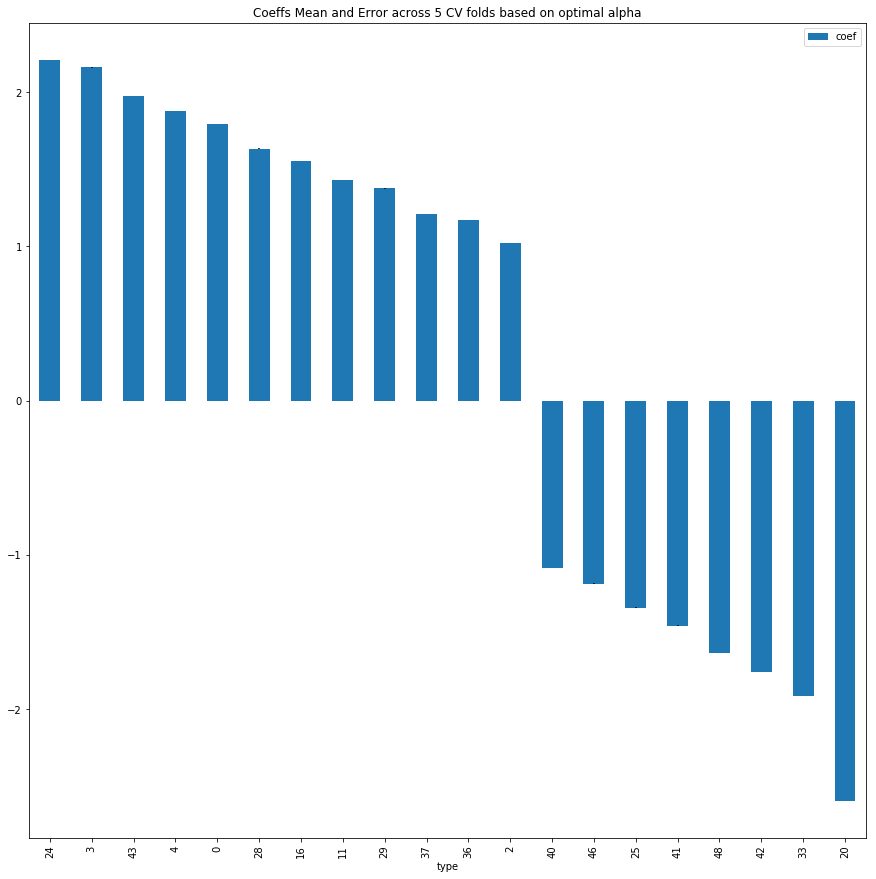

In [7]:
dfCoeffs = pd.DataFrame({'type':X.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs = dfCoeffs[(dfCoeffs['coef']>1) |(dfCoeffs['coef']<-1) ]

dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
dfCoeffs_sorted
yerr_vals = dfCoeffs_sorted['std'].values

dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,figsize=(15,15))
plt.title("Coeffs Mean and Error across 5 CV folds based on optimal alpha")
plt.show()

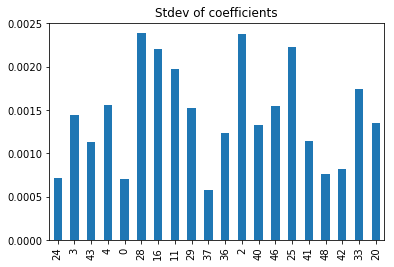

In [8]:
dfCoeffs_sorted['std'].plot(kind="bar",title="Stdev of coefficients")
plt.show()

You can barely see the error in the plots above because the standard deviation of these coefficients is so small relative to the mean.